## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres:


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

## 1. Visualicemos los datos

In [742]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
import pandas as pd
from scipy import stats
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno
from datetime import datetime

import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv1D, MaxPooling1D, Activation, Dropout, Flatten, Dense
from keras import applications

from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [743]:
# Importemos los datos y visualizemos la serie de tiempo
data = pd.read_csv("5658240.txt", delimiter='\t', encoding="utf8")
data = data.drop('Unnamed: 6', 1)
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente26,18/09/2017,20,700,VER0049,Yerbabuena / 100 gramos
1,Cliente26,18/09/2017,10,1200,FRU0024,Limón Tahití / Libra
2,Cliente26,18/09/2017,4,1600,VER0041,Puerro / Libra
3,Cliente26,18/09/2017,10,1500,VER0038,Pimentón Rojo / Libra
4,Cliente26,18/09/2017,8,1100,VER0010,Zucchini Verde / Libra


Veamos los clientes con mayor participación en la demanda:

<AxesSubplot:ylabel='Pedido'>

Text(0.5, 1.0, 'Cantidad de productos adquiridos por cada cliente')

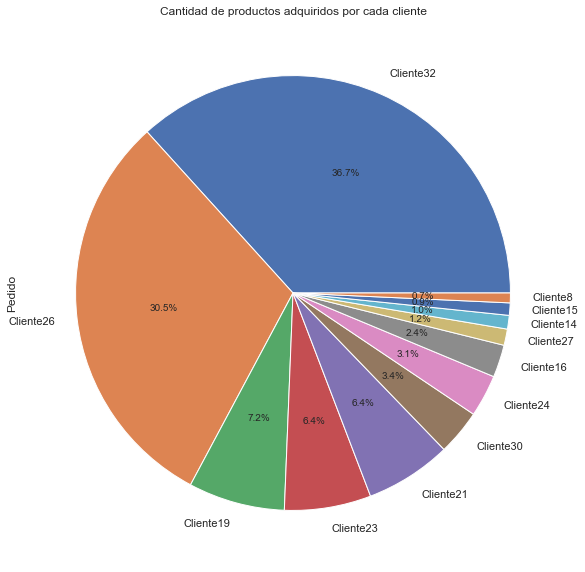

In [744]:
cliente = pd.DataFrame(data[data['Pedido'] > 10].groupby(data["Cliente"]).sum())
cliente2 = cliente[cliente['Pedido']>50]
cliente3 = cliente2.sort_values("Pedido", ascending= False)
cliente3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%')
plt.title("Cantidad de productos adquiridos por cada cliente")
plt.show()

Vemaos los productos con más volumen de pedido:

<AxesSubplot:ylabel='Pedido'>

Text(0.5, 1.0, 'Cantidad de productos adquiridos por producto')

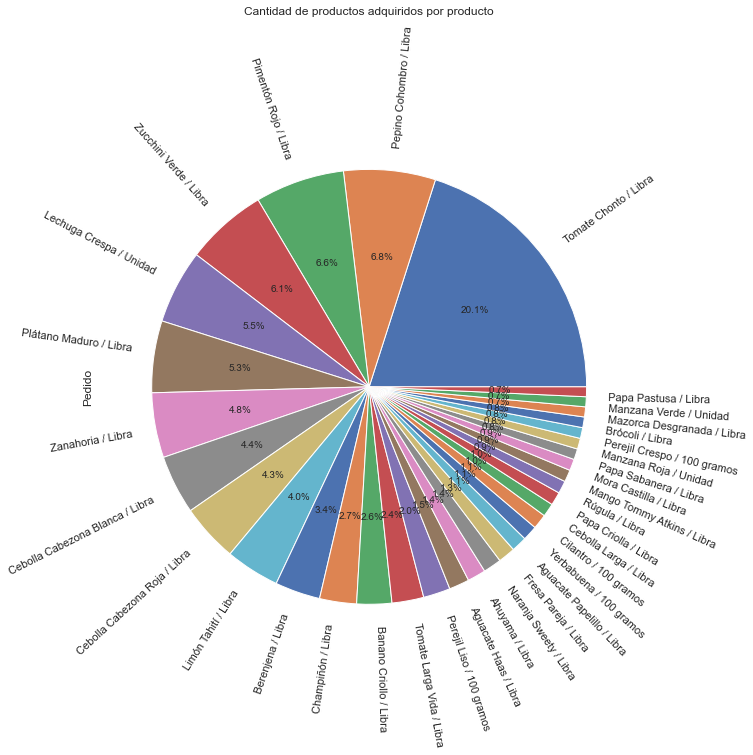

In [745]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Nombre_producto"]).sum())
productos2 = productos[productos['Pedido']>140]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

A continuación implemente la metodología propuesta para construir su modelo:

# 1. Analisis Descriptivo

Procederemos a relizar una exploracion de los datos, para observar sus particularidades.

## 1.1 Evaluación de Valores Faltantes

In [746]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Cliente          4708 non-null   object
 1   Fecha            4712 non-null   object
 2   Pedido           4712 non-null   int64 
 3   Precio           4712 non-null   int64 
 4   Producto         4712 non-null   object
 5   Nombre_producto  4712 non-null   object
dtypes: int64(2), object(4)
memory usage: 221.0+ KB


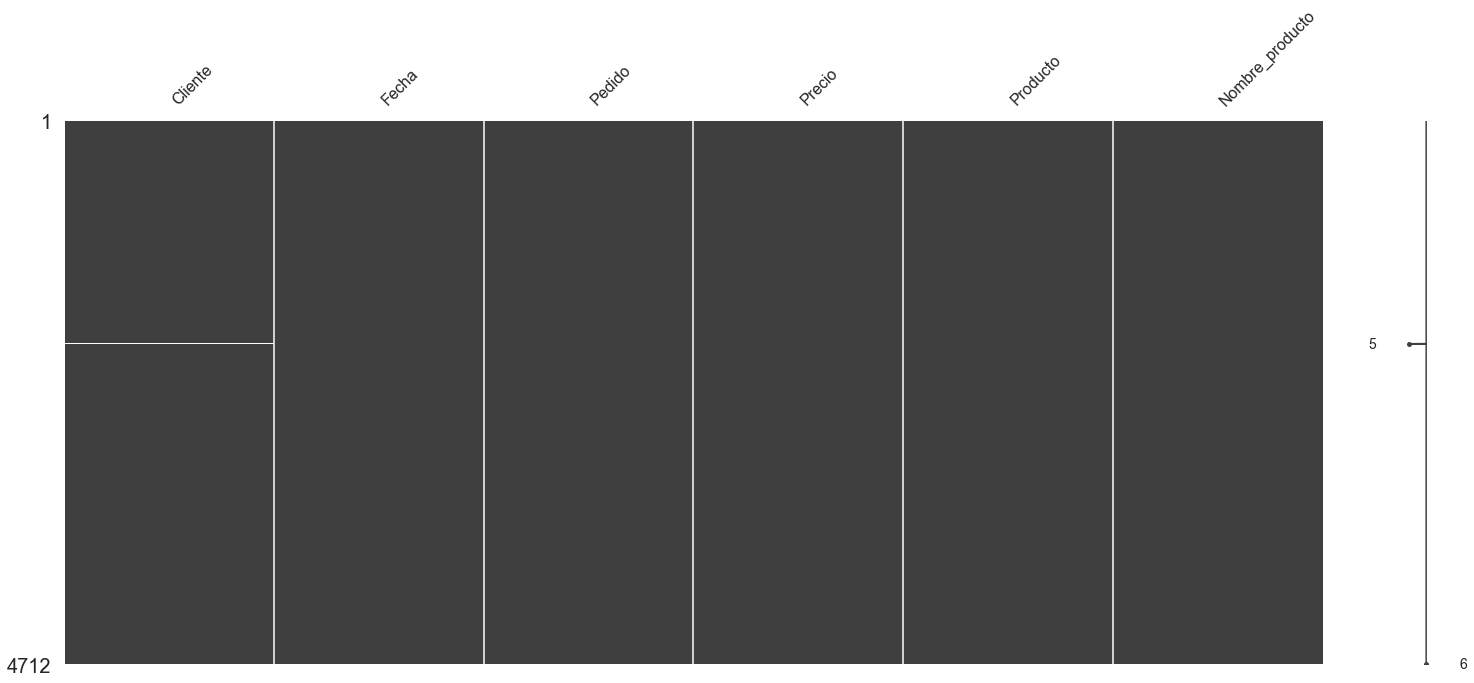

In [747]:
# Generamos un mapa con el fin de visualizar los valores faltantes (missing values)
msno.matrix(data);

Podemos ver que hay 4 valores faltantes en los datos de los clientes.

In [748]:
data[data.isna().any(axis=1)]

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
1932,NaN,19/06/2017,40,1450,FRU0046,Tomate Chonto / Libra
1933,NaN,19/06/2017,10,2100,VER0012,Cebolla Cabezona Blanca / Libra
1934,NaN,19/06/2017,8,1700,VER0038,Pimentón Rojo / Libra
1935,NaN,19/06/2017,6,650,VER0035,Pepino Cohombro / Libra


## 1.2 Revisión Variables Numericas

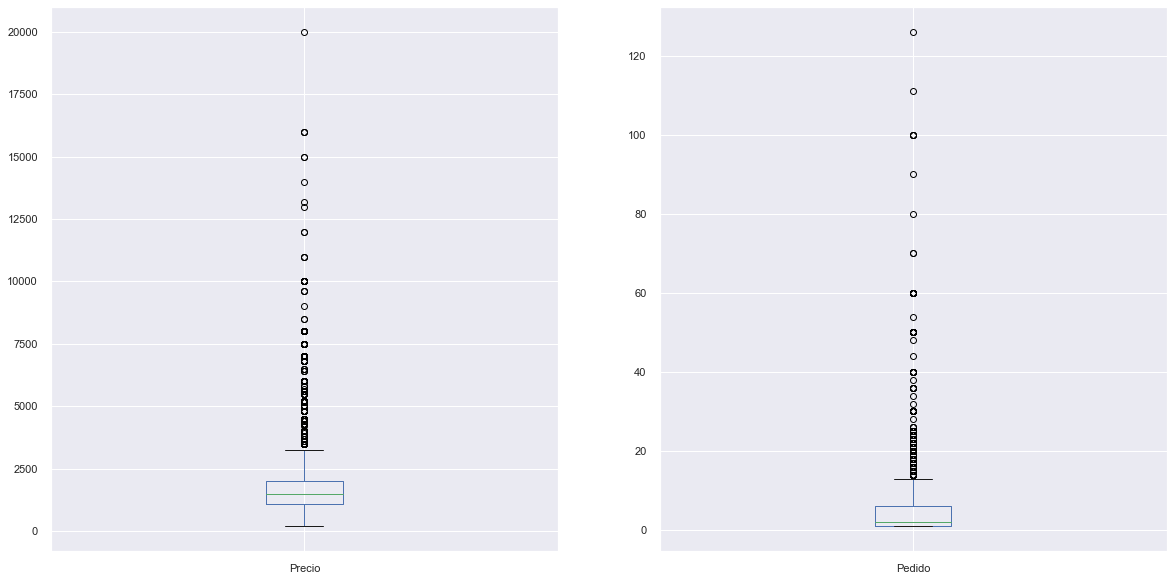

In [749]:
cols = ["Precio","Pedido"]
data[cols].plot(kind="box",subplots=True,figsize=(20, 10));

## 1.3 Revision de Variables Categoricas

In [750]:
pd.DataFrame(data["Cliente"].value_counts()).head(10)

,Cliente
Cliente32,932
Cliente29,862
Cliente21,584
Cliente3,411
Cliente16,193
Cliente10,193
Cliente19,184
Cliente2,182
Cliente22,169
Cliente13,168


In [751]:
pd.DataFrame(data["Producto"].value_counts())

,Producto
FRU0046,355
VER0035,223
VER0016,204
VER0028,174
VER0010,164
...,...
TUB0003,1
VER050,1
FRU0052,1
GRA0011,1


In [752]:
pd.DataFrame(data["Nombre_producto"].value_counts())

,Nombre_producto
Tomate Chonto / Libra,355
Pepino Cohombro / Libra,223
Champiñón / Libra,204
Lechuga Crespa / Unidad,174
Zucchini Verde / Libra,164
...,...
Zucchini Amarillo / Libra,1
Cubio / Libra,1
Zapote,1
Lenteja,1


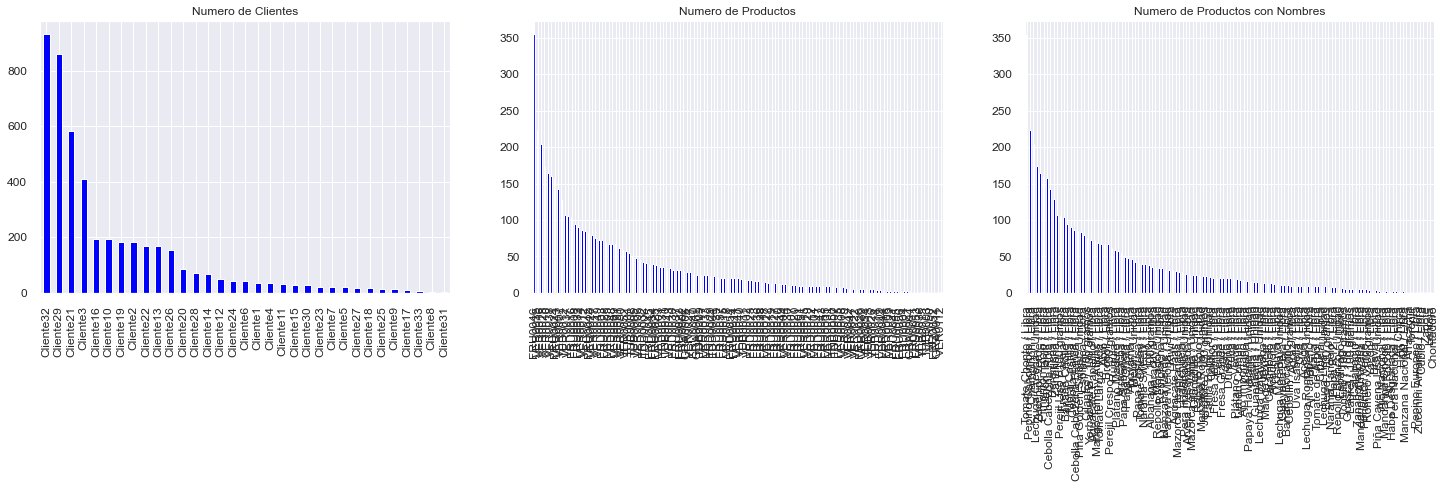

In [753]:
# Se crean las tablas, sumando los valores que se tienen para cada categoria
Cli = pd.DataFrame(data["Cliente"].value_counts())
Pro = pd.DataFrame(data["Producto"].value_counts())
NP = pd.DataFrame(data["Nombre_producto"].value_counts())

# Creamos la figura donde dibujaremos las graficas
fig , axarr = plt.subplots(1,3,figsize=(25,5))

# Dibujamos cada grafica
Cli["Cliente"].plot.bar(ax=axarr[0],fontsize=12,title="Numero de Clientes",color="blue")
Pro["Producto"].plot.bar(ax=axarr[1],fontsize=12,title="Numero de Productos",color = "blue")
NP["Nombre_producto"].plot.bar(ax=axarr[2],fontsize=12,title="Numero de Productos con Nombres",color="blue")

# Cambiamos el espaciamiento entre las graficas
plt.subplots_adjust(hspace=.8);

Podemos observar que hay demasiados tipos de productos (221) y hay productos en los cuales solo se han hecho pedidos esporadicos, por esto se hará necesario centrarnos en el analisis/predicción de las los productos que consideraremos "importantes".

## 1.4 Extracción de Series de Tiempo de Productos Relevantes

Agruparemos nuestros datos por producto y evaluaremos la media del numero de pedidos y su precio:

In [754]:
df=data.groupby(by="Producto").sum().sort_values(by="Precio", ascending=False)
df.head(10)

,Pedido,Precio
Producto,,
VER0016,547,1505800
FRU0046,4000,531550
VER0051,160,365900
FRU0042,110,292980
VER0028,1094,271300
VER0038,1324,266750
VER0010,1211,218500
VER0013,858,217800
FRU0032,45,207700


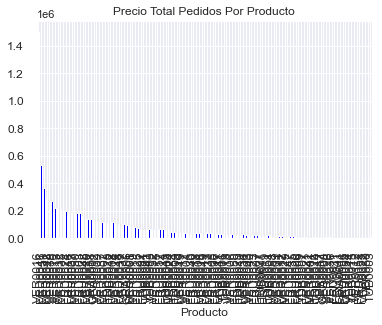

In [755]:
df["Precio"].plot.bar(fontsize=12,title="Precio Total Pedidos Por Producto",color="blue");

In [756]:
df[df.Pedido<10]

,Pedido,Precio
Producto,,
VER0019,7,82800
FRU0004,2,36000
FRU0050,9,28950
VER0053,4,17700
FRU0021,2,6400
TUB0014,8,6000
GRA0004,3,4700
VER0036,3,4000
FRU0011,3,3920


Realizaremos un analisis de Pareto para observar las distribuciones y capturar solamente las variables que representen el 80% del volumen de ventas, con el fin de que la prediccion de haga sobre los productos cuyas perdidas impacten economicamente en gran medida.

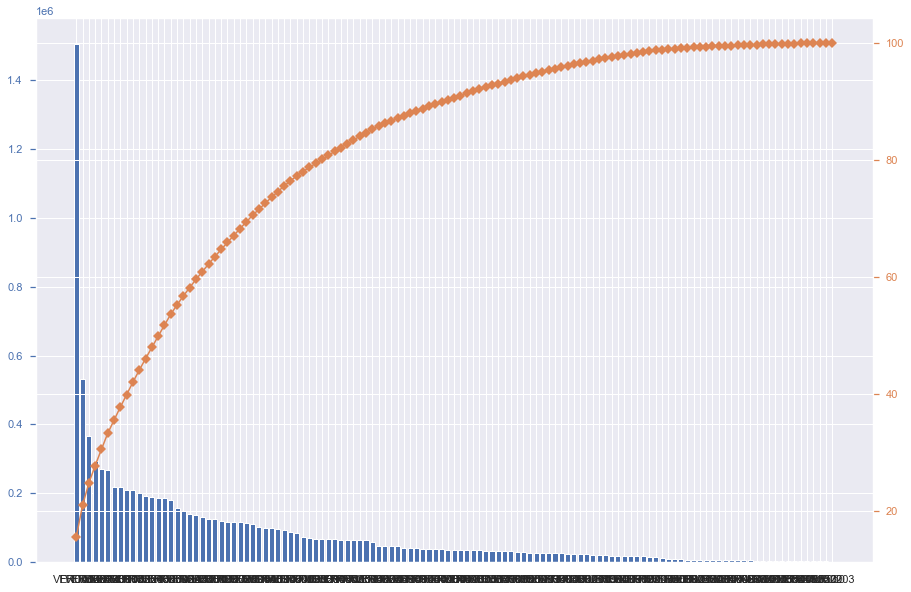

In [757]:
import matplotlib.ticker as mtick

df["cumpercentage"] = df["Precio"].cumsum()/df["Precio"].sum()*100

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(df.index, df.Precio, color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
#x2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=5))

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show();

In [758]:
df

,Pedido,Precio,cumpercentage
Producto,,,
VER0016,547,1505800,15.471745
FRU0046,4000,531550,20.933298
VER0051,160,365900,24.692836
FRU0042,110,292980,27.703137
VER0028,1094,271300,30.490682
...,...,...,...
FRU0052,3,2400,99.937324
FRU0053,1,2000,99.957873
VER0022,33,1800,99.976368


In [759]:
df[df.cumpercentage<=80]

,Pedido,Precio,cumpercentage
Producto,,,
VER0016,547,1505800,15.471745
FRU0046,4000,531550,20.933298
VER0051,160,365900,24.692836
FRU0042,110,292980,27.703137
VER0028,1094,271300,30.490682
VER0038,1324,266750,33.231476
VER0010,1211,218500,35.476513
VER0013,858,217800,37.714357
FRU0032,45,207700,39.848427


In [760]:
var_red=df[df.cumpercentage<=80].index
var_red

Index(['VER0016', 'FRU0046', 'VER0051', 'FRU0042', 'VER0028', 'VER0038',
       'VER0010', 'VER0013', 'FRU0032', 'VER0035', 'FRU0024', 'FRU0016',
       'FRU0033', 'VER0007', 'VER0050', 'FRU0003', 'FRU0022', 'FRU0045',
       'VER0020', 'FRU0038', 'GRA0001', 'VER0012', 'VER0009', 'FRU0037',
       'VER0002', 'FRU0028', 'TUB0012', 'FRU0008', 'VER0014', 'FRU0048',
       'FRU0039', 'VER0037', 'GRA0006', 'FRU0001', 'VER0005', 'VER0019',
       'FRU0025', 'FRU0002', 'FRU0031'],
      dtype='object', name='Producto')

De esta manera podemos extraer los tipos de producto que que representan el 80% de las compras de los clientes.

In [761]:
pd.DataFrame(data.loc[data.Producto==var_red[38],["Fecha","Pedido"]]).head()

,Fecha,Pedido
254,08/09/2017,1
285,06/09/2017,1
517,28/08/2017,3
558,26/08/2017,2
577,25/08/2017,3


In [762]:
var_red[38]

'FRU0031'

In [763]:
Series = {}
i=0
for prod in var_red:
    Series[prod] = pd.DataFrame(data.loc[data.Producto==var_red[i],["Fecha","Pedido"]])
    Series[prod]["Fecha"] = pd.to_datetime(Series[prod]["Fecha"])
    Series[prod].set_index('Fecha',inplace=True)
    Series[prod]=Series[prod].sort_index(ascending=True)
    Series[prod]=Series[prod].resample("w").mean()
    Series[prod]=Series[prod].fillna(0)
    i=i+1

In [764]:
Series["VER0016"].head(10)

,Pedido
Fecha,
2016-01-17,1.0
2016-01-24,0.0
2016-01-31,0.0
2016-02-07,0.0
2016-02-14,3.0
2016-02-21,0.0
2016-02-28,0.0
2016-03-06,0.0
2016-03-13,0.0


Graficaremos ahora las Series de tiempo de los productos considerados relevantes:

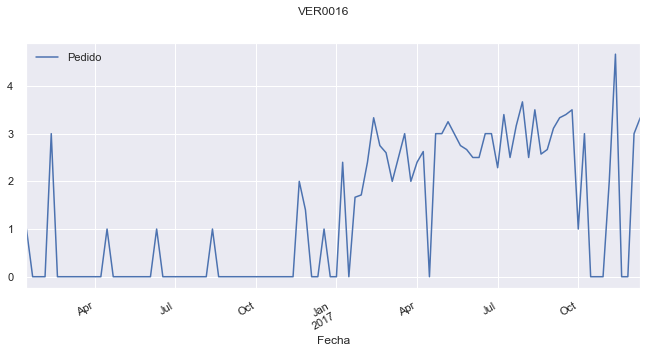

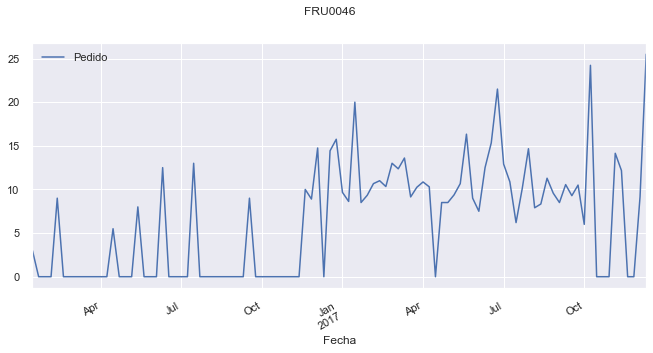

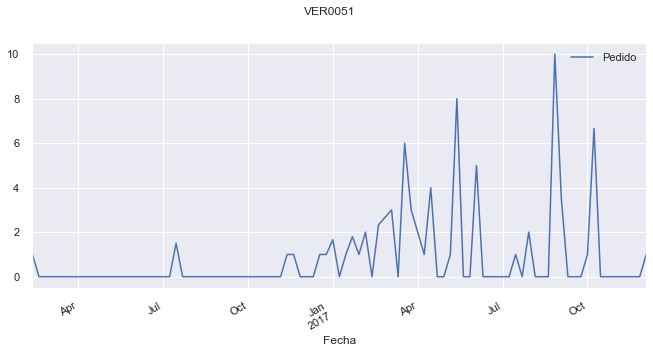

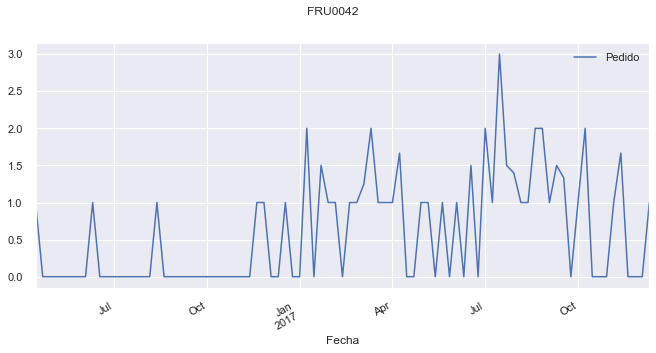

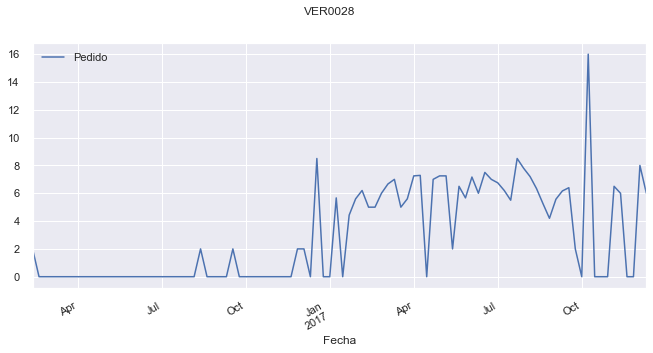

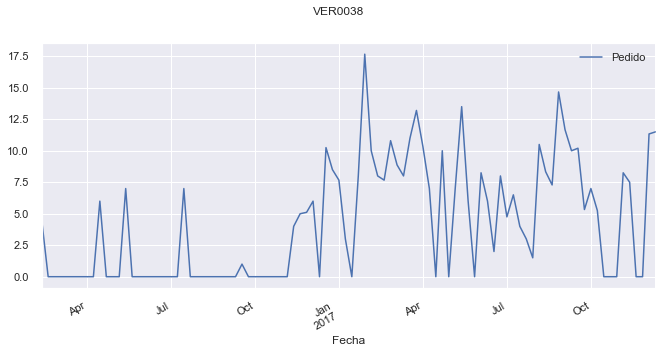

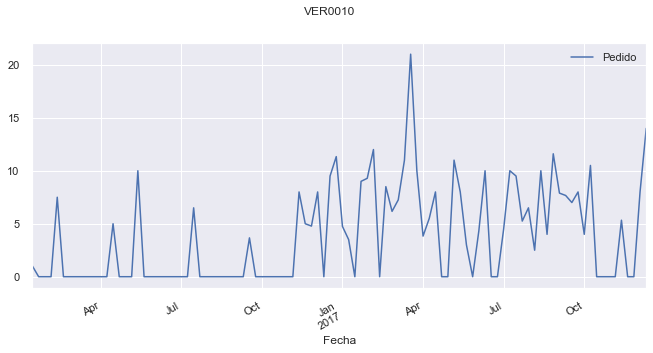

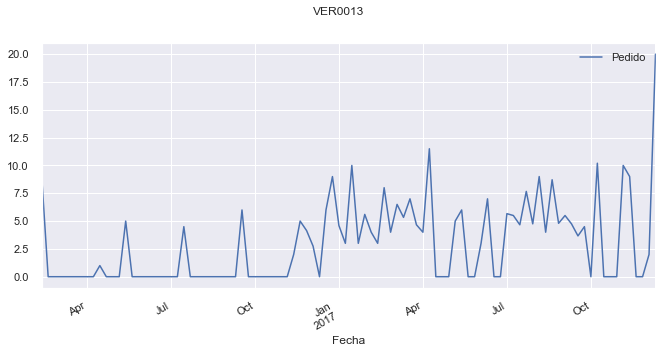

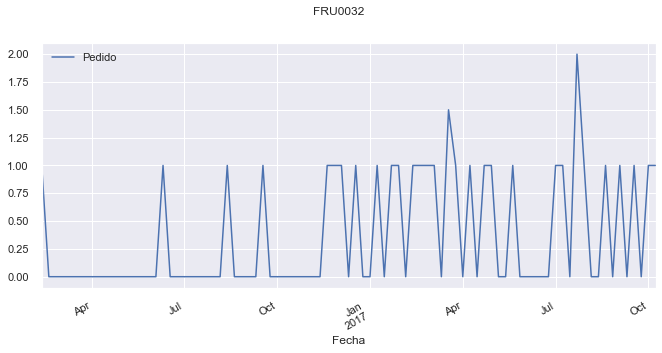

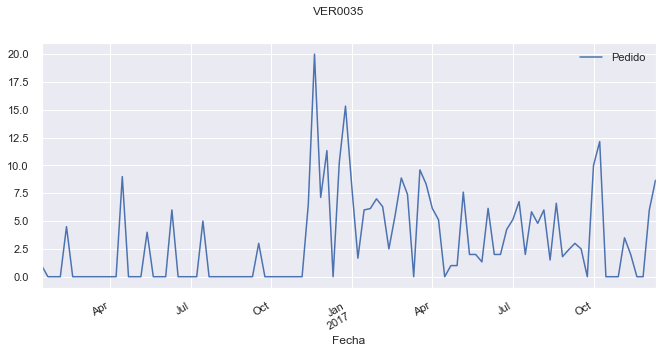

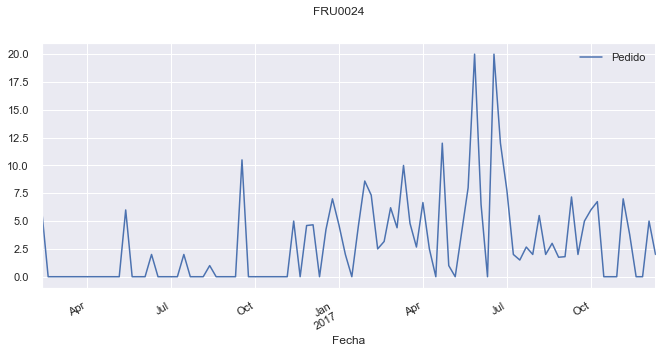

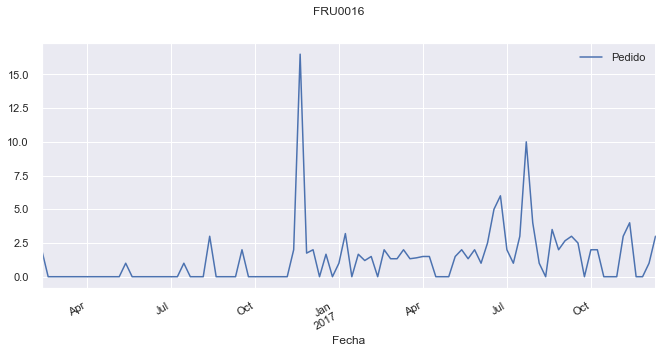

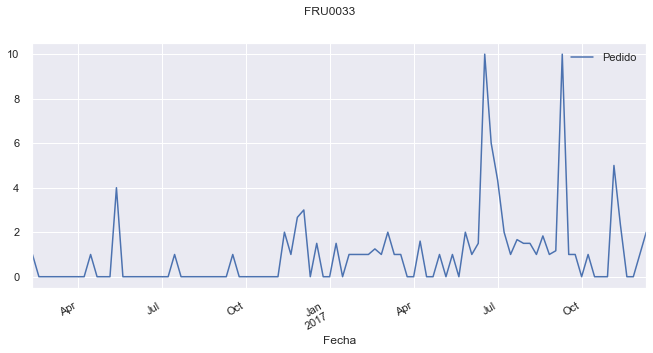

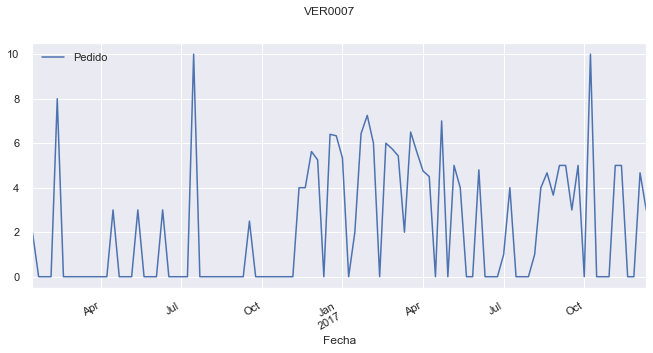

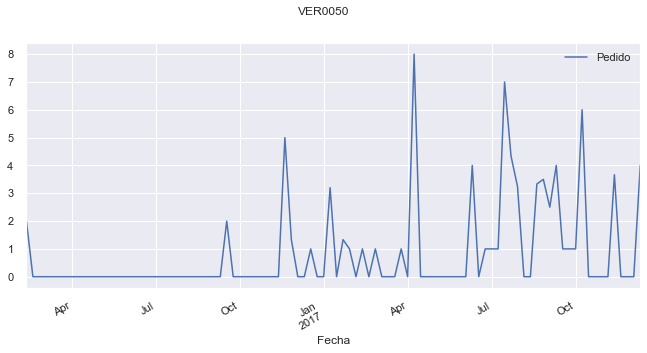

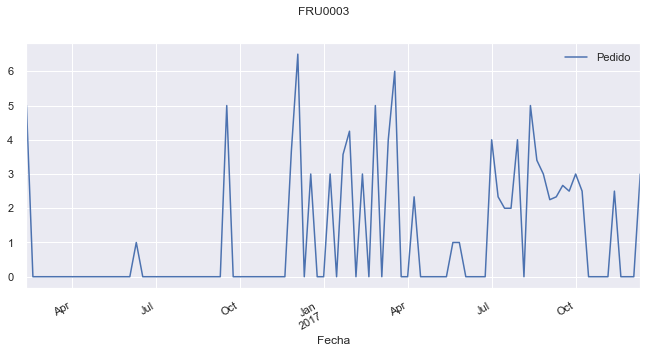

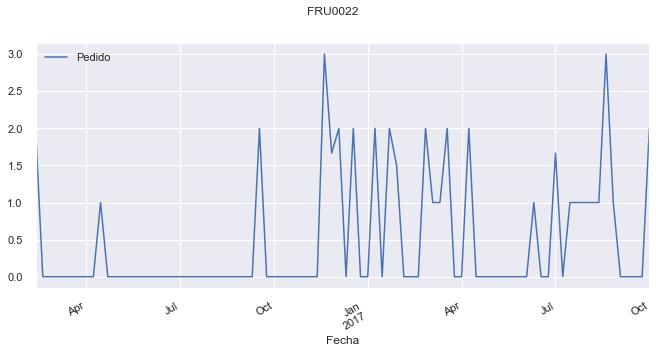

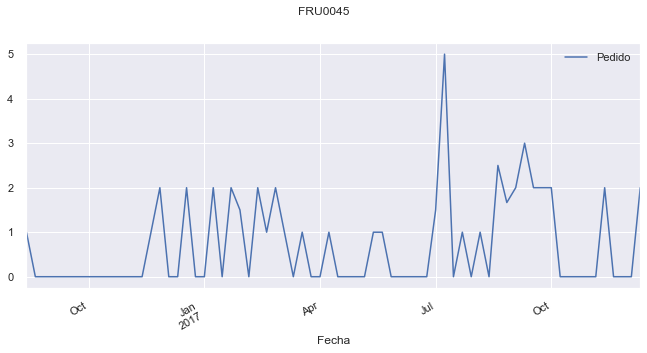

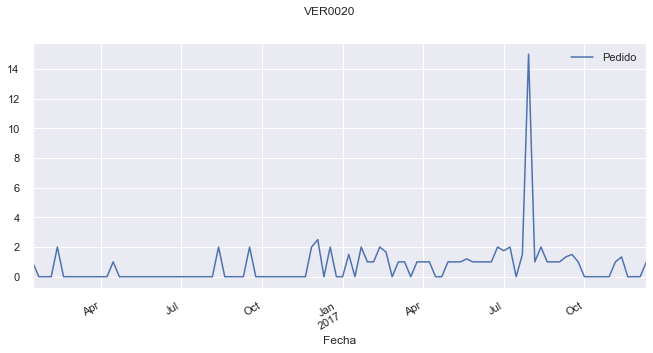

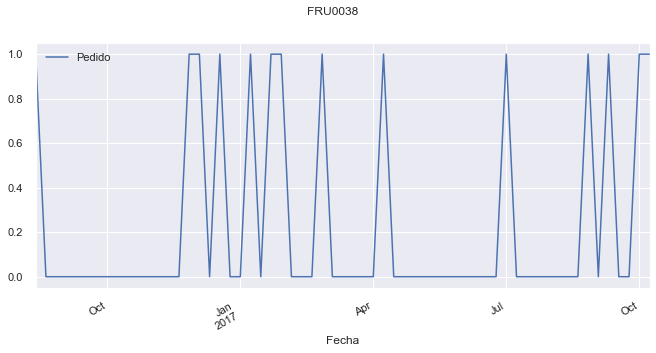

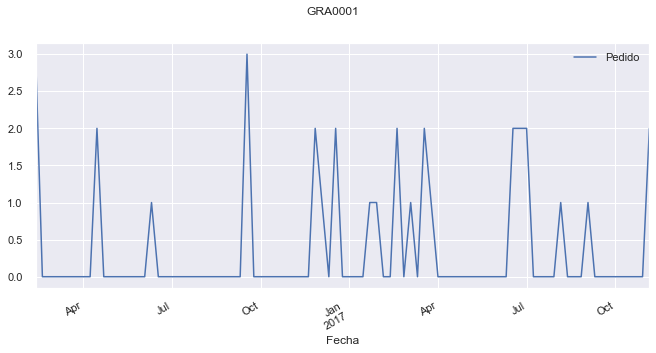

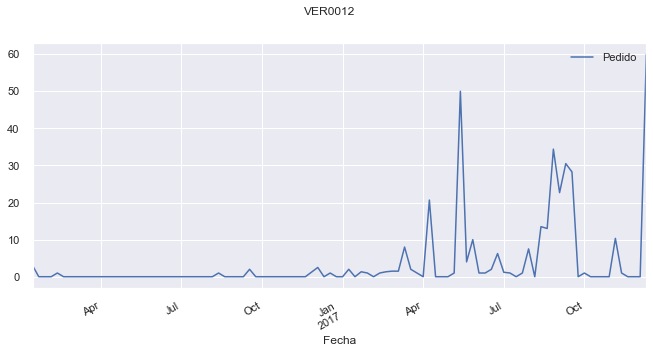

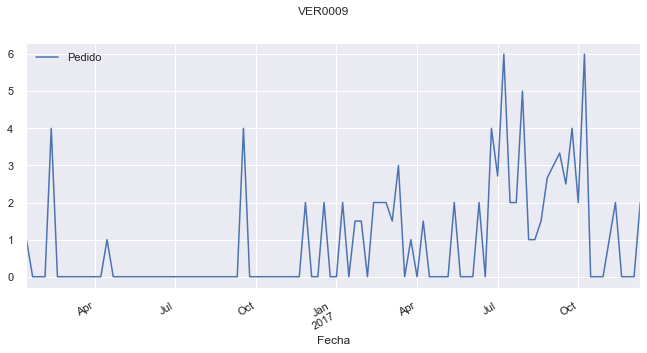

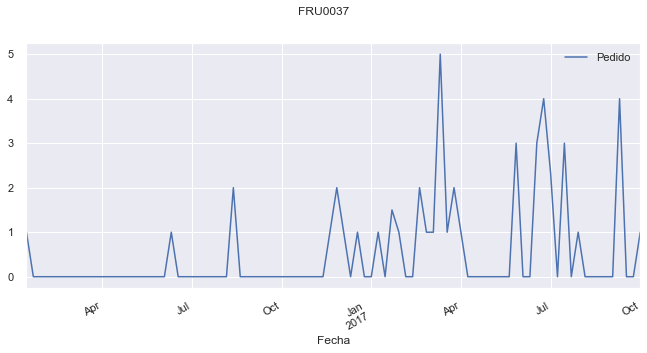

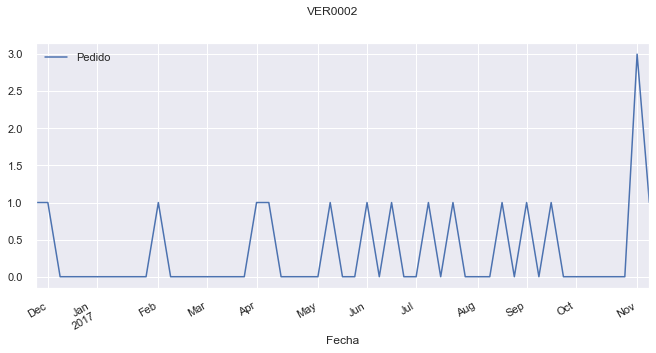

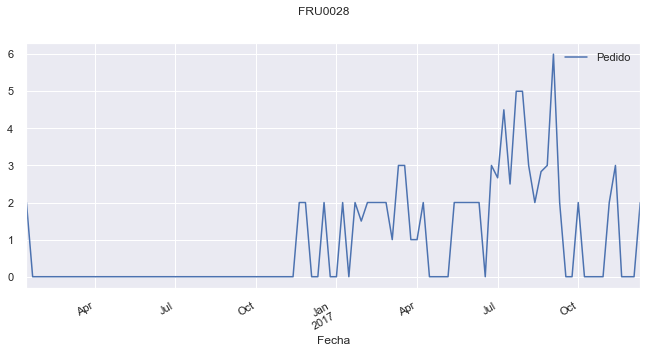

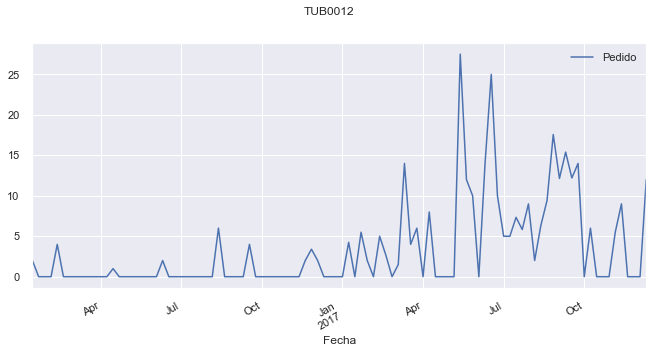

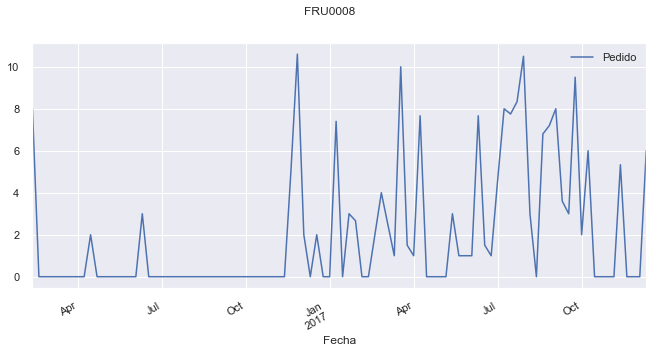

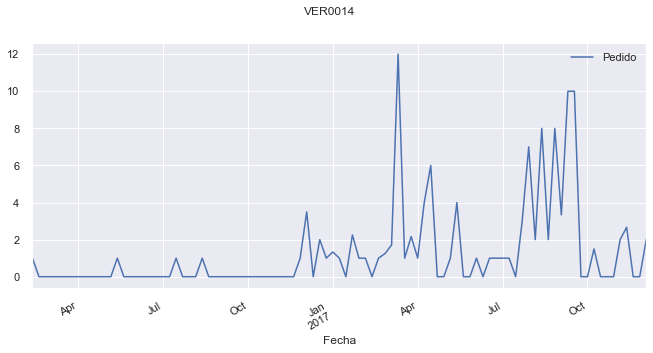

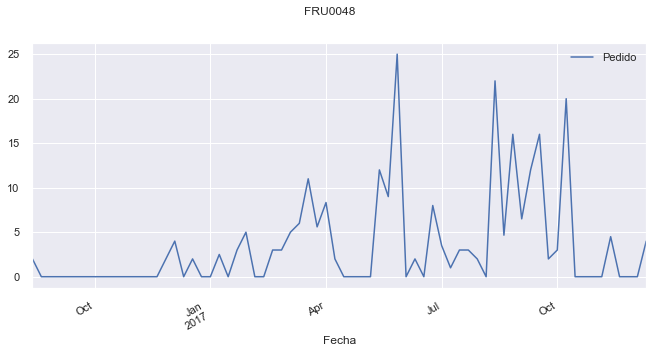

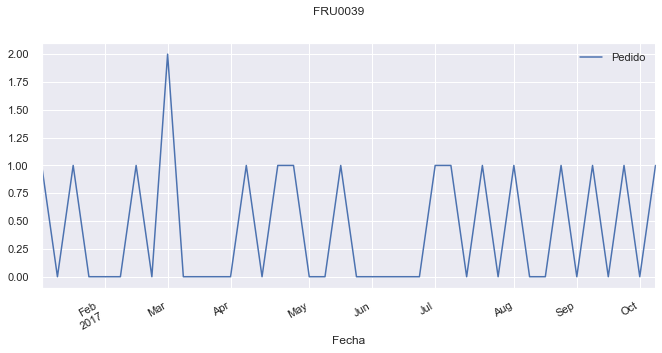

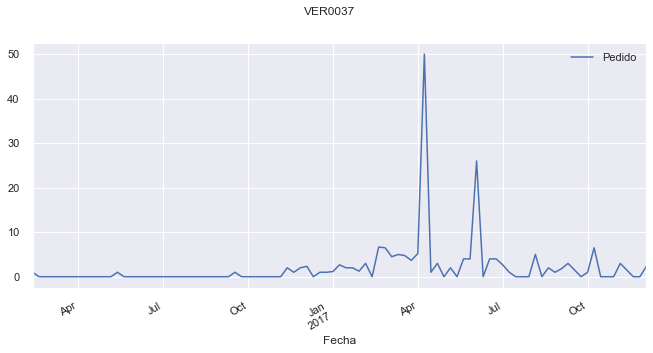

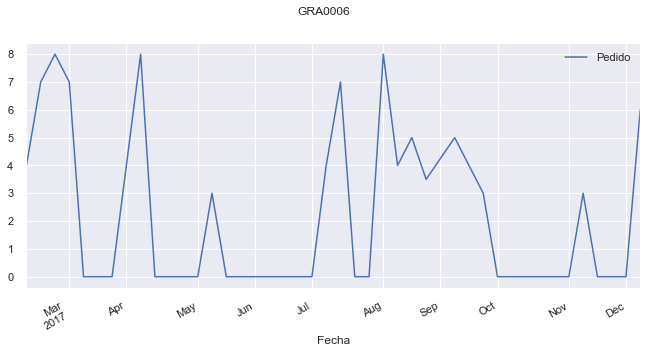

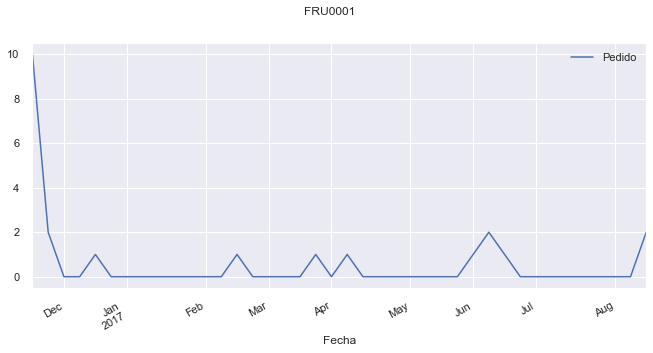

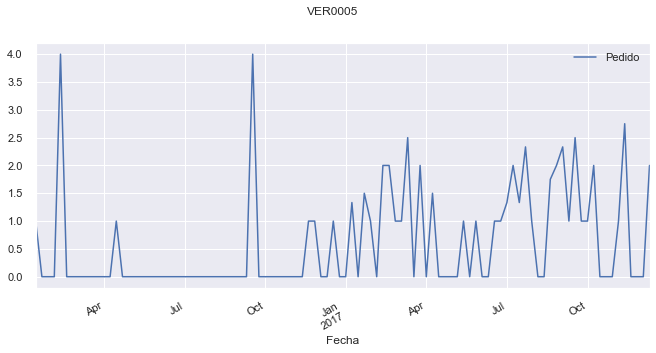

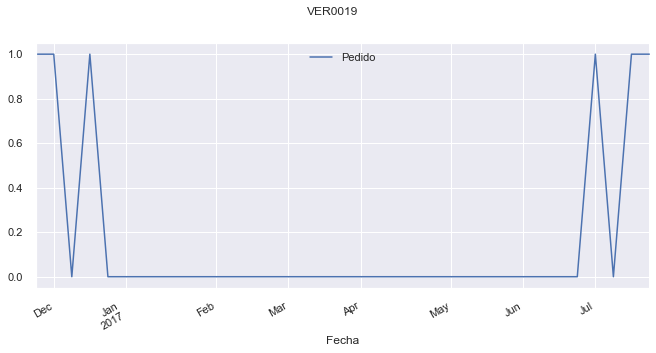

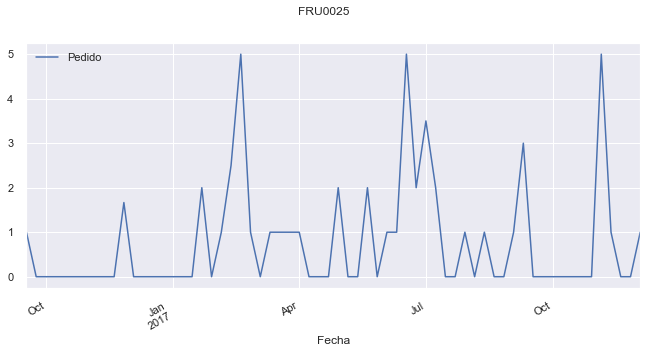

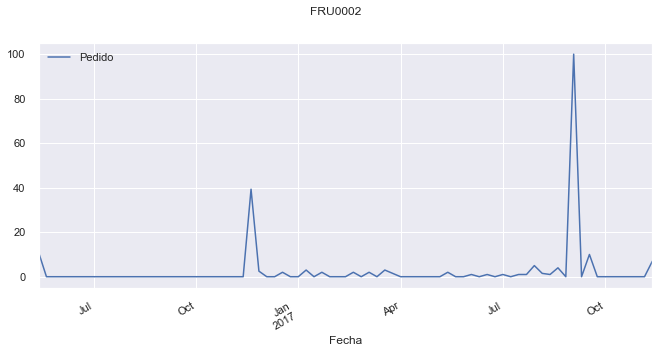

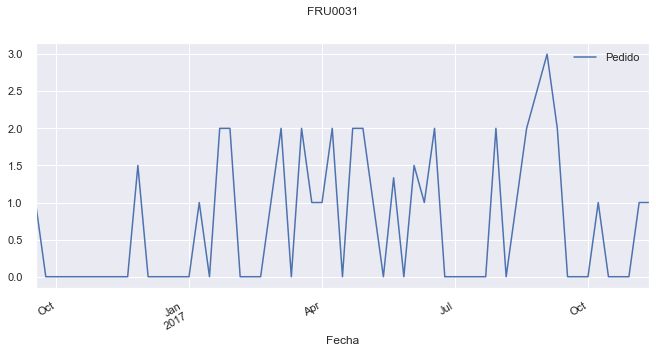

In [765]:
plt.rcParams.update({'figure.max_open_warning': 0})

for prod in var_red:
    ax = Series[prod].plot(linestyle='-', figsize=(11, 5), subplots=True,title=prod);

# 2. Modelos de Prediccion

## 2.1 NN

<Figure size 720x432 with 0 Axes>

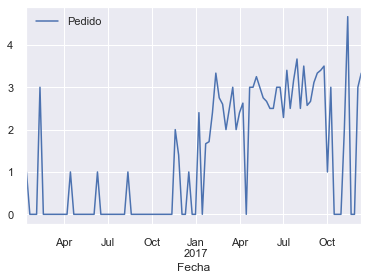

In [849]:
plt.figure(figsize=(10, 6))
Series["VER0016"].plot();

<Figure size 720x432 with 0 Axes>

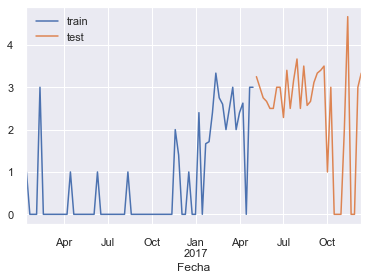

In [850]:
split_date = pd.Timestamp('2017-05-01')
df =  Series["VER0016"]
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [851]:
pd.DataFrame(train)

,Pedido
Fecha,
2016-01-17,1.000
2016-01-24,0.000
2016-01-31,0.000
2016-02-07,0.000
2016-02-14,3.000
...,...
2017-04-02,2.400
2017-04-09,2.625
2017-04-16,0.000


In [852]:
# scale train and test data to [-1, 1]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(pd.DataFrame(train))
test_sc = scaler.transform(pd.DataFrame(test))

In [853]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [858]:
pd.DataFrame(X_train).head()

,0
0,-0.4
1,-1.0
2,-1.0
3,-1.0
4,0.8


In [859]:
pd.DataFrame(y_train).head()

,0
0,-1.0
1,-1.0
2,-1.0
3,0.8
4,-1.0


In [771]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(24, input_dim=1, activation='relu'))
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
67/67 [==============================] - 0s 1ms/step - loss: 0.7130
Epoch 2/100
67/67 [==============================] - 0s 963us/step - loss: 0.4405
Epoch 3/100
67/67 [==============================] - 0s 936us/step - loss: 0.3299
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3106
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3032
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 0.2999
Epoch 7/100
67/67 [==============================] - 0s 1ms/step - loss: 0.2956
Epoch 8/100
67/67 [==============================] - 0s 1ms/step - loss: 0.2933
Epoch 9/100
67/67 [==============================] - 0s 921us/step - loss: 0.2918
Epoch 10/100
67/67 [==============================] - 0s 1ms/step - loss: 0.2903
Epoch 11/100
67/67 [==============================] - 0s 1ms/step - loss: 0.2897
Epoch 12/100
67/67 [==============================] - 0s 1ms/step - loss: 0.2889
Epoch 13/100
67/67 [===========

## LSTM

In [776]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.values#.as_matrix()
y_train = y_train.values#.as_matrix()

X_test = X_test.values#.as_matrix()
y_test = y_test.values#.as_matrix()

In [778]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (67, 1, 1)
Test shape:  (31, 1, 1)


In [797]:
lstm_model = Sequential()
lstm_model.add(LSTM(6, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
67/67 [==============================] - 0s 1ms/step - loss: 0.8017
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 0.6233
Epoch 3/100
67/67 [==============================] - 0s 1ms/step - loss: 0.4944
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.4075
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3540
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3243
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3089
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3010
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 0.2967
Epoch 10/100
67/67 [==============================] - 0s 2ms/step - loss: 0.2942
Epoch 11/100
67/67 [==============================] - 0s 2ms/step - loss: 0.2925
Epoch 12/100
67/67 [==============================] - 0s 2ms/step - loss: 0.2913
Epoch 13/100
67/67 [=================

In [798]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.369
The R2 score on the Test set is:	-0.245


In [799]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

31/31 [==============================] - 0s 909us/step - loss: 0.6791
NN: 0.664527
LSTM: 0.679126


In [800]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

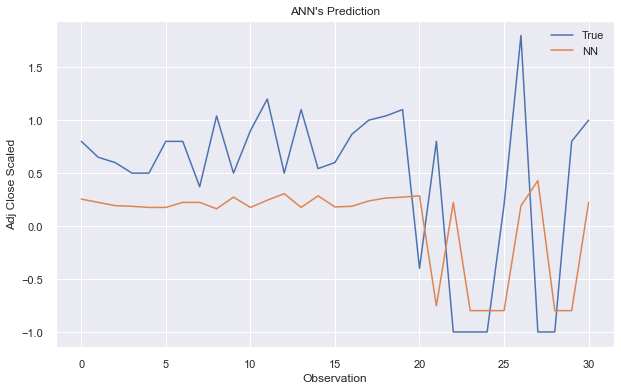

In [801]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

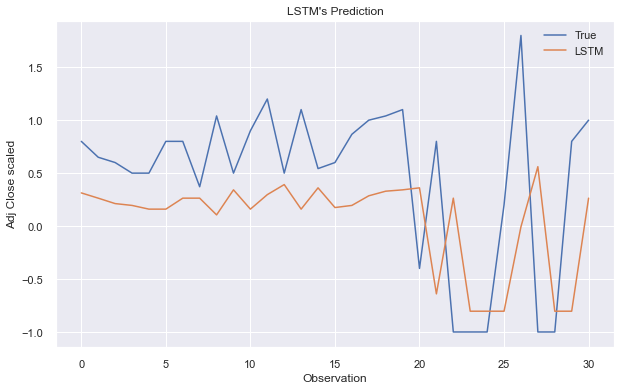

In [802]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();

## CNN

<Figure size 720x432 with 0 Axes>

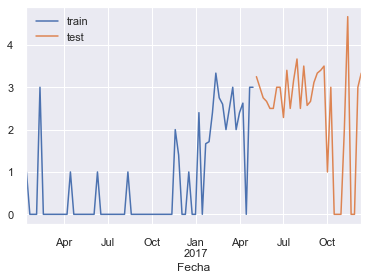

In [886]:
split_date = pd.Timestamp('2017-05-01')
df =  Series["VER0016"]
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [887]:
train

,Pedido
Fecha,
2016-01-17,1.000
2016-01-24,0.000
2016-01-31,0.000
2016-02-07,0.000
2016-02-14,3.000
...,...
2017-04-02,2.400
2017-04-09,2.625
2017-04-16,0.000


In [888]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(pd.DataFrame(train))
test_sc = scaler.transform(pd.DataFrame(test))

In [889]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [890]:
pd.DataFrame(X_train).head()

,0
0,-0.4
1,-1.0
2,-1.0
3,-1.0
4,0.8


In [891]:
pd.DataFrame(y_train).head()

,0
0,-1.0
1,-1.0
2,-1.0
3,0.8
4,-1.0


In [910]:
np.shape(X_train)

(67, 1, 1)

In [893]:
np.shape(y_train)

(67, 1)

In [897]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])

In [943]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()
model.add(Conv1D(filters = 2, kernel_size = 1,input_shape=(67,1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='relu'))
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

model.compile(optimizer='adam', loss='mse')

In [944]:
model.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 67, 3)             6         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 67, 3)             0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 201)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 1000)              202000    
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 1001      
Total params: 203,007
Trainable params: 203,007
Non-trainable params: 0
_________________________________________________________________


In [945]:
# fit model
model.fit(X_train, y_train, epochs=200, verbose=0)

ValueError: in user code:

    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\pc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_110 is incompatible with the layer: expected axis -1 of input shape to have value 201 but received input with shape [None, 3]
